Imports libraries.

Defines a normalize() function to clean text (uppercase, strip spaces, remove non-alphanumeric).

Loads Kenya’s subcounty shapefile (layer 2) from GADM.

Creates standardized county and subcounty name columns (COUNTY_NORM, SUBCOUNTY_NORM).

In [30]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import re

def normalize(s):
    return (
        s.astype(str)
        .str.upper()
        .str.strip()
        .str.replace(r"[^A-Z0-9]", "", regex=True)
    )

# --- Load shapefile ---
gdf = gpd.read_file(
    "https://geodata.ucdavis.edu/gadm/gadm4.0/gpkg/gadm40_KEN.gpkg",
    layer=2
)
gdf["COUNTY_NORM"] = normalize(gdf["NAME_1"])
gdf["SUBCOUNTY_NORM"] = normalize(gdf["NAME_2"])

# --- Assign codes ---
county_map_gdf = {c: i+1 for i, c in enumerate(sorted(gdf["COUNTY_NORM"].unique()))}
gdf["COUNTY_CODE"] = gdf["COUNTY_NORM"].map(county_map_gdf)

sub_map_gdf = gdf.groupby("COUNTY_NORM")["SUBCOUNTY_NORM"].apply(
    lambda x: {sc: i+1 for i, sc in enumerate(sorted(x.unique()))}
)
gdf["SUBCOUNTY_CODE"] = gdf.apply(
    lambda r: sub_map_gdf[r["COUNTY_NORM"]].get(r["SUBCOUNTY_NORM"]), axis=1
)

print("✅ Shapefile prepared with codes")
print(gdf.head())


✅ Shapefile prepared with codes
  ID_0 COUNTRY   NAME_1 NL_NAME_1       ID_2           NAME_2 VARNAME_2  \
0  KEN   Kenya  Baringo            KEN.1.1_1              805             
1  KEN   Kenya  Baringo            KEN.1.2_1  Baringo Central             
2  KEN   Kenya  Baringo            KEN.1.3_1    Baringo North             
3  KEN   Kenya  Baringo            KEN.1.4_1    Baringo South             
4  KEN   Kenya  Baringo            KEN.1.5_1    Eldama Ravine             

  NL_NAME_2        TYPE_2     ENGTYPE_2 CC_2 HASC_2  \
0            Constituency  Constituency  162          
1            Constituency  Constituency  159          
2            Constituency  Constituency  158          
3            Constituency  Constituency  160          
4            Constituency  Constituency  162          

                                            geometry COUNTY_NORM  \
0  MULTIPOLYGON (((35.87727 -0.02973, 35.87699 -0...     BARINGO   
1  MULTIPOLYGON (((35.7977 0.3395, 35.79765 0.339.

Processing the Population Dataset

In this step, I prepare the subcounty-level population data for mapping:

Load the dataset from GitHub.

Standardize county and subcounty names using the normalize() function so they match with the shapefile.

Convert columns to numeric:

Age → ensures we only keep valid numeric age values (non-numeric entries like “TOTAL” are dropped).

Total → converts population counts to numbers and replaces missing values with 0.

Filter the dataset to remove unwanted entries:

Drop rows where subcounty = "ALL". This is the data for counties. In the data the the total county data is given the name all in the data set

Keep only valid age records.

Aggregate population totals by county and subcounty.

Apply a threshold filter to retain only subcounties with a population of at least 2,000. To remove the data of sub counties not included in the map shape like MT-Kenya and Abardares



In [29]:
# --- Load population dataset ---
df = pd.read_csv(
    "https://raw.githubusercontent.com/ChiriKamau/soma/main/data/Population_scounty_age_gender.csv"
)
df["COUNTY_NORM"] = normalize(df["ewcounty"])
df["SUBCOUNTY_NORM"] = normalize(df["sub-county"])
df["Age"] = df["Age"].astype(str).str.strip()

# Keep only numeric ages
df_clean = df[df["Age"].str.isdigit()].copy()
df_clean["Age"] = pd.to_numeric(df_clean["Age"], errors="coerce")
df_clean["Total"] = pd.to_numeric(df_clean["Total"], errors="coerce").fillna(0)

# --- Keep only ages between 3 and 20 ---
df_filtered = df_clean[(df_clean["Age"] >= 3) & (df_clean["Age"] <= 20)]

# Remove "ALL" subcounty rows
df_sub = df_filtered[df_filtered["SUBCOUNTY_NORM"] != "ALL"]

# --- Aggregate totals by subcounty ---
pop_totals = (
    df_sub.groupby(["COUNTY_NORM", "SUBCOUNTY_NORM"], as_index=False)["Total"]
    .sum()
    .rename(columns={"Total": "SubcountyTotal"})
)

# --- Filter BEFORE assigning codes ---
pop_totals = pop_totals[pop_totals["SubcountyTotal"] >= 2000]

# --- Assign codes ---
county_map_df = {c: i+1 for i, c in enumerate(sorted(pop_totals["COUNTY_NORM"].unique()))}
pop_totals["COUNTY_CODE"] = pop_totals["COUNTY_NORM"].map(county_map_df)

sub_map_df = pop_totals.groupby("COUNTY_NORM")["SUBCOUNTY_NORM"].apply(
    lambda x: {sc: i+1 for i, sc in enumerate(sorted(x.unique()))}
)
pop_totals["SUBCOUNTY_CODE"] = pop_totals.apply(
    lambda r: sub_map_df[r["COUNTY_NORM"]].get(r["SUBCOUNTY_NORM"]), axis=1
)

print("✅ Population dataset with codes")
print(pop_totals.head())


✅ Population dataset with codes
  COUNTY_NORM  SUBCOUNTY_NORM  SubcountyTotal  COUNTY_CODE  SUBCOUNTY_CODE
0     BARINGO  BARINGOCENTRAL         44930.0            1             1.0
1     BARINGO    BARINGONORTH         52631.0            1             2.0
2     BARINGO       EASTPOKOT         47317.0            1             3.0
3     BARINGO        KOIBATEK         59237.0            1             4.0
4     BARINGO         MARIGAT         47177.0            1             5.0


Merged the 2 data sets the map and the population

In [26]:

# --- Merge shapefile with population using codes ---
gdf_merged = gdf.merge(
    pop_totals,
    on=["COUNTY_CODE", "SUBCOUNTY_CODE"],
    how="left",
    suffixes=("_shp", "_pop")
)

# Fill missing population values with 0
gdf_merged["SubcountyTotal"] = gdf_merged["SubcountyTotal"].fillna(0)

print("✅ Shapefile + Population joined using codes")
print(gdf_merged.head())


✅ Shapefile + Population joined using codes
  ID_0 COUNTRY   NAME_1 NL_NAME_1       ID_2           NAME_2 VARNAME_2  \
0  KEN   Kenya  Baringo            KEN.1.1_1              805             
1  KEN   Kenya  Baringo            KEN.1.2_1  Baringo Central             
2  KEN   Kenya  Baringo            KEN.1.3_1    Baringo North             
3  KEN   Kenya  Baringo            KEN.1.4_1    Baringo South             
4  KEN   Kenya  Baringo            KEN.1.5_1    Eldama Ravine             

  NL_NAME_2        TYPE_2     ENGTYPE_2 CC_2 HASC_2  \
0            Constituency  Constituency  162          
1            Constituency  Constituency  159          
2            Constituency  Constituency  158          
3            Constituency  Constituency  160          
4            Constituency  Constituency  162          

                                            geometry COUNTY_NORM_shp  \
0  MULTIPOLYGON (((35.87727 -0.02973, 35.87699 -0...         BARINGO   
1  MULTIPOLYGON (((35.7977 0.3

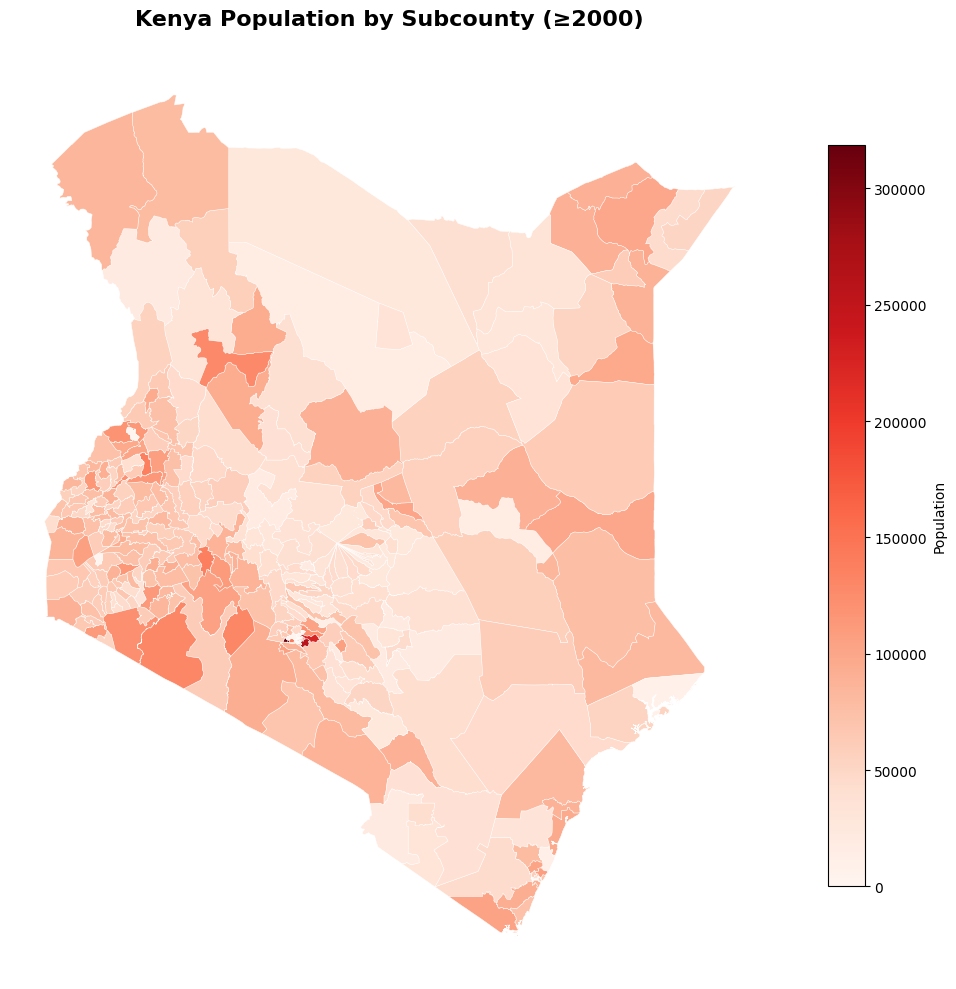

Map created using your coding system
Mapped 292 subcounties with population data
Population range: 0 - 318,484

TOP 10 HIGHEST POPULATION SUBCOUNTIES:
 1. Dagoretti South, Nairobi: 318,484
 2. Embakasi East, Nairobi: 258,403
 3. Kasarani, Nairobi: 225,398
 4. Dagoretti North, Nairobi: 144,831
 5. Molo, Nakuru: 138,840
 6. Likuyani, Bungoma: 137,040
 7. Narok West, Narok: 130,399
 8. Narok East, Narok: 129,925
 9. unknown 2, Turkana: 126,988
10. Kilgoris, Narok: 122,658

TOP 10 LOWEST POPULATION SUBCOUNTIES:
 1. Lamu East, Lamu: 9,527
 2. Kilifi South, Kilifi: 11,914
 3. Thika Town, Kiambu: 14,683
 4. Balambala, Garissa: 17,540
 5. Laisamis, Marsabit: 18,647
 6. Laikipia West, Laikipia: 19,689
 7. Kitui East, Kitui: 20,701
 8. Mwingi West, Kitui: 20,820
 9. Loima, Turkana: 20,909
10. Nyeri Town, Nyeri: 21,080

SUMMARY STATISTICS:
Total subcounties with data: 292
Average population: 66,125
Median population: 61,617


In [27]:


# --- Plot map ---
fig, ax = plt.subplots(figsize=(12, 10))
gdf_merged.plot(
    column="SubcountyTotal",
    cmap="Reds",
    ax=ax,
    edgecolor="white",
    linewidth=0.3
)
sm = plt.cm.ScalarMappable(
    cmap="Reds",
    norm=plt.Normalize(
        vmin=gdf_merged["SubcountyTotal"].min(),
        vmax=gdf_merged["SubcountyTotal"].max()
    )
)
sm.set_array([])
plt.colorbar(sm, ax=ax, shrink=0.8, label="Population")
ax.set_title("Kenya Population by Subcounty (≥2000)", fontsize=16, fontweight="bold", pad=20)
ax.axis("off")
plt.tight_layout()
plt.show()

# --- Reports ---
print("Map created using your coding system")
print(f"Mapped {len(gdf_merged[gdf_merged['SubcountyTotal'] > 0])} subcounties with population data")
print(f"Population range: {int(gdf_merged['SubcountyTotal'].min()):,} - {int(gdf_merged['SubcountyTotal'].max()):,}\n")

populated = gdf_merged[gdf_merged["SubcountyTotal"] > 0]

print("TOP 10 HIGHEST POPULATION SUBCOUNTIES:")
print("="*50)
for i, row in populated.nlargest(10, "SubcountyTotal")[["NAME_2", "NAME_1", "SubcountyTotal"]].reset_index(drop=True).iterrows():
    print(f"{i+1:2d}. {row['NAME_2']}, {row['NAME_1']}: {int(row['SubcountyTotal']):,}")

print("\nTOP 10 LOWEST POPULATION SUBCOUNTIES:")
print("="*50)
for i, row in populated.nsmallest(10, "SubcountyTotal")[["NAME_2", "NAME_1", "SubcountyTotal"]].reset_index(drop=True).iterrows():
    print(f"{i+1:2d}. {row['NAME_2']}, {row['NAME_1']}: {int(row['SubcountyTotal']):,}")

print("\nSUMMARY STATISTICS:")
print(f"Total subcounties with data: {len(populated):,}")
print(f"Average population: {int(populated['SubcountyTotal'].mean()):,}")
print(f"Median population: {int(populated['SubcountyTotal'].median()):,}")
